## This is the faster way to access the data remotely using NetCDF files

This method of accessint the data remotely from the THREDDS server is significantly faster than loading the data into local memory because only the data that are selected are loaded. This example is for calculating accumulated rain for one day.

In [10]:
import xarray as xr  # a toolset for reading netcdf files

# plot directly in notebook
%matplotlib inline   

Once we have these tools, we can load the dataset and inspect it

In [11]:
remote_data = xr.open_dataset('http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/UrbanRainfall/Phoenix.nc')
print remote_data

<xarray.Dataset>
Dimensions:       (station: 311, time: 1206737)
Coordinates:
    lat           (station) float64 ...
    lon           (station) float64 ...
  * time          (time) datetime64[ns] 1980-05-02T03:00:00 ...
  * station       (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    rain_gage     (station, time) float64 ...
    station_name  (station) |S64 ...
Attributes:
    featureType: timeSeries
    Conventions: CF-1.6
    description: Phoenix rain gage network
    history: Created 2016-02-16 20:29:05.096112
    DODS.strlen: 6
    DODS.dimName: string6


Select a time of interest and then aggregate over the time dimension. In this case I chose a known storm 

In [128]:
ds = remote_data.sel(time='2014-08-19').sum('time')
print ds

<xarray.Dataset>
Dimensions:       (station: 311)
Coordinates:
    lat           (station) float64 ...
    lon           (station) float64 ...
  * station       (station) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    rain_gage     (station) float64 0.0 0.0 0.0 0.0 0.0 27.94 8.128 23.11 ...
    station_name  (station) |S64 ...


Move this xarray.Dataset object into a pandas.DataFrame for easy manipulation. And then move it from there to a rain.Event object.

In [129]:
from rain import *   # tool in this repo

df = ds.to_dataframe()
e = Event(df)

Use the Event.map_rain function to generate a map

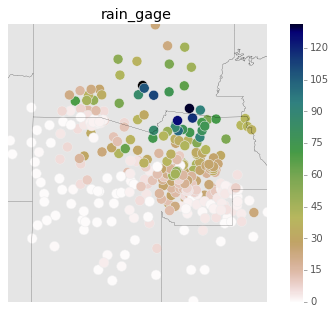

In [130]:
e.map_rain(basemap=True)

Use the Event.kride function to generate an interpolated map (this will take awhile)

[using ordinary kriging]


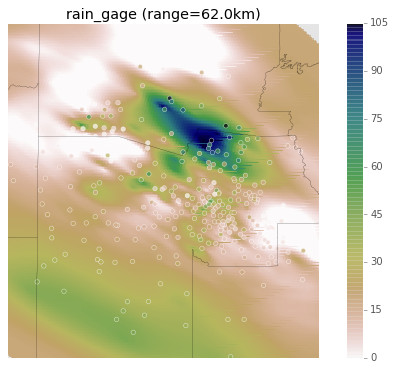

In [131]:
e.krige(basemap=True)

Sometimes we might want to grab a particular slice of the data and aggregate it. Xarray makes this easy! In this example we find the days for which there are large numbers of gages with accumulated rainfall greater than 25mm. 

In [132]:
#choose just the slice of time for which we have reliable data and drop gages that have missing values in that time
ds_recent = remote_data['rain_gage'].sel(time=slice('2012-06','2014-08')).dropna('station', how='any')

#resample to daily accumulations
ds_day = ds_recent.resample('24H', 'time', base=12, how='sum', label='right')

#convert to pandas.DataFrame object and just take the summer months
df = ds_day.to_pandas().T
df = df[(df.index.month>=6) & (df.index.month<=8)]

#count the number of gages on each day that get more then 25mm of rain
ngages_over_25mm = df[df>25].count(axis=1)
ngages_over_25mm.sort_values(ascending=False).head(20)

time
2014-08-20 12:00:00    93
2014-08-13 12:00:00    57
2012-07-15 12:00:00    54
2012-08-23 12:00:00    43
2012-08-22 12:00:00    37
2013-07-22 12:00:00    18
2013-08-25 12:00:00    16
2013-08-27 12:00:00    15
2012-07-30 12:00:00    14
2014-08-03 12:00:00    14
2013-08-31 12:00:00    12
2014-08-26 12:00:00    11
2012-07-22 12:00:00    10
2014-07-07 12:00:00     9
2014-07-16 12:00:00     7
2014-07-15 12:00:00     6
2014-07-09 12:00:00     6
2013-08-30 12:00:00     6
2012-08-17 12:00:00     6
2013-08-29 12:00:00     5
dtype: int64